In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Preparation

In [2]:
# read file housing csv
df = pd.read_csv('housing.csv')

In [3]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

c:\Users\imamx\anaconda3\envs\mlzoomcamp2023\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\imamx\anaconda3\envs\mlzoomcamp2023\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of prices')

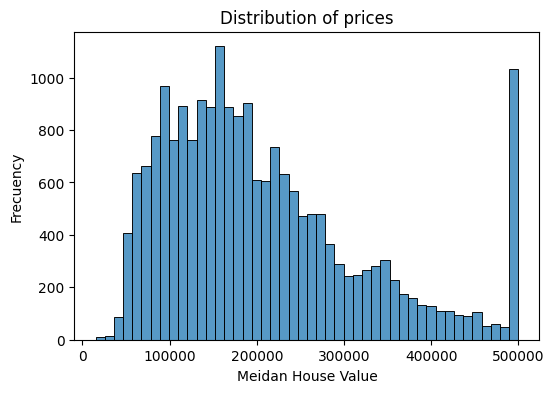

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(df['median_house_value'])
plt.ylabel('Frecuency')
plt.xlabel('Meidan House Value')
plt.title('Distribution of prices')

### EDA

In [12]:
column_selected = ['latitude', 
                   'longitude', 
                   'housing_median_age', 
                   'total_rooms', 
                   'total_bedrooms', 
                   'population', 
                   'households', 
                   'median_income', 
                   'median_house_value']

In [6]:
df_selected = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])][column_selected]

### Question 1.

There is one feature with missing values. What is it?

In [7]:
df_selected.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2.

What's the median (50% percentile) for variable `'population'`?

In [8]:
np.median(df_selected['population'])

1195.0

### Prepare and Split Dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [9]:
np.random.seed(42)

n = len(df_selected)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_selected.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [10]:
y_train_orig = df_train['median_house_value'].values
y_val_orig = df_val['median_house_value'].values
y_test_orig  = df_test['median_house_value'].values

y_train = np.log1p(df_train['median_house_value'].values)
y_val = np.log1p(df_val['median_house_value'].values)
y_test = np.log1p(df_test['median_house_value'].values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [11]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [14]:
base = ['longitude', 
        'latitude', 
        'housing_median_age', 
        'total_rooms',
        'total_bedrooms', 
        'population', 
        'households', 
        'median_income']

def prepare_X(df, value):
    df_num = df[base]
    df_num = df_num.fillna(value)
    X = df_num.values
    return X 

In [15]:
# X train with fillna 0
X_train_0 = prepare_X(df_train, 0)
w_0, w = train_linear_regression(X_train_0, y_train)

In [16]:
y_pred_0 = w_0 + X_train_0.dot(w)

In [17]:
# X train with fillna mean
X_train_mean = prepare_X(df_train, df_selected['total_bedrooms'].mean())
w_0, w = train_linear_regression(X_train_mean, y_train)

In [18]:
y_pred_mean = w_0 + X_train_mean.dot(w)

In [19]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2 ).mean()
    return np.sqrt(mse)

In [20]:
rmse_0 = round(rmse(y_train, y_pred_0), 2)
rmse_0

0.34

In [21]:
rmse_mean = round(rmse(y_train, y_pred_mean), 2)
rmse_mean

0.34

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [22]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg 

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [23]:
X_train = prepare_X(df_train, 0)
X_val = prepare_X(df_val, 0)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred), 2))

     0 0.34
 1e-06 0.34
0.0001 0.34
 0.001 0.34
  0.01 0.34
   0.1 0.34
     1 0.34
     5 0.35
    10 0.35


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

In [37]:
def split_df(seed):
    np.random.seed(seed)
    n = len(df_selected)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df_selected.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()

    y_train_orig = df_train['median_house_value'].values
    y_val_orig = df_val['median_house_value'].values
    y_test_orig  = df_test['median_house_value'].values

    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [38]:
list_rmse = []
list_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

for i in list_seed:
    seed = split_df(i)
    X_train = prepare_X(seed[0], 0)
    w_0, w = train_linear_regression(X_train, seed[3])
    y_pred = w_0 + X_train.dot(w)
    rmse_ = rmse(seed[3], y_pred)
    list_rmse.append(rmse_)

In [39]:
std_deviation_rmse = round(np.std(np.round(list_rmse,2)),3)
std_deviation_rmse

0.005

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [42]:
df_split = split_df(9)
df_train_new = pd.concat([df_split[0], df_split[1]])

In [43]:
y_train_new = np.concatenate([df_split[3], df_split[4]])

In [44]:
X_train_new = prepare_X(df_train_new, 0)
X_test = prepare_X(df_split[2], 0)
w_0, w = train_linear_regression_reg(X_train_new, y_train_new, r=0.001)
y_pred = w_0 + X_test.dot(w)
print(round(rmse(df_split[5], y_pred), 2))

0.33
